In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install lightning
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

In [3]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import HelocDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

In [4]:
dataset = HelocDataset("../data/heloc.csv")

In [5]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=5000,
    patience=100,
    lr=1e-3,
    checkpoint_path="heloc_disc_model.pt",
)
# disc_model.load("heloc_disc_model.pt")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

In [6]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [7]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.7260759493670886


In [8]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [9]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model.fit(
    train_dataloader,
    train_dataloader,
    learning_rate=1e-3,
    patience=100,
    num_epochs=500,
    checkpoint_path="heloc_flow.pth",
)
gen_model.load("heloc_flow.pth")

Epoch 499, Train: -29.7402, test: -29.5851, patience: 24: 100%|██████████| 500/500 [03:25<00:00,  2.43it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

In [10]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [11]:
dataset.actionable_features = [4, 17, 18, 19, 20]
dataset.not_actionable_features = [
    i for i in range(dataset.X_train.shape[1]) if i not in dataset.actionable_features
]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    # TODO: poprawa nazewnictwa
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 3246.6899, dist: 1.2383, max_inner: 25.6132, loss_disc: 0.0125, delta_loss: 560.2780: 100%|██████████| 3000/3000 [00:47<00:00, 63.80it/s] 


Correct: 933/1105
6


{'coverage': 1.0,
 'validity': 0.9746606334841629,
 'actionability': 0.0,
 'sparsity': 0.21739130434782608,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.680751968044552,
 'proximity_continuous_manhattan': 1.237928660644846,
 'proximity_continuous_euclidean': 0.680751968044552,
 'proximity_continuous_mad': 24.507249553829055,
 'proximity_l2_jaccard': 0.680751968044552,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.10226244343891402,
 'log_density_cf': 5.5206084,
 'log_density_test': 26.10766,
 'lof_scores_cf': 1.7035695,
 'lof_scores_test': 1.0889314,
 'isolation_forest_scores_cf': -0.004247794601286573,
 'isolation_forest_scores_test': 0.05416284678798596}

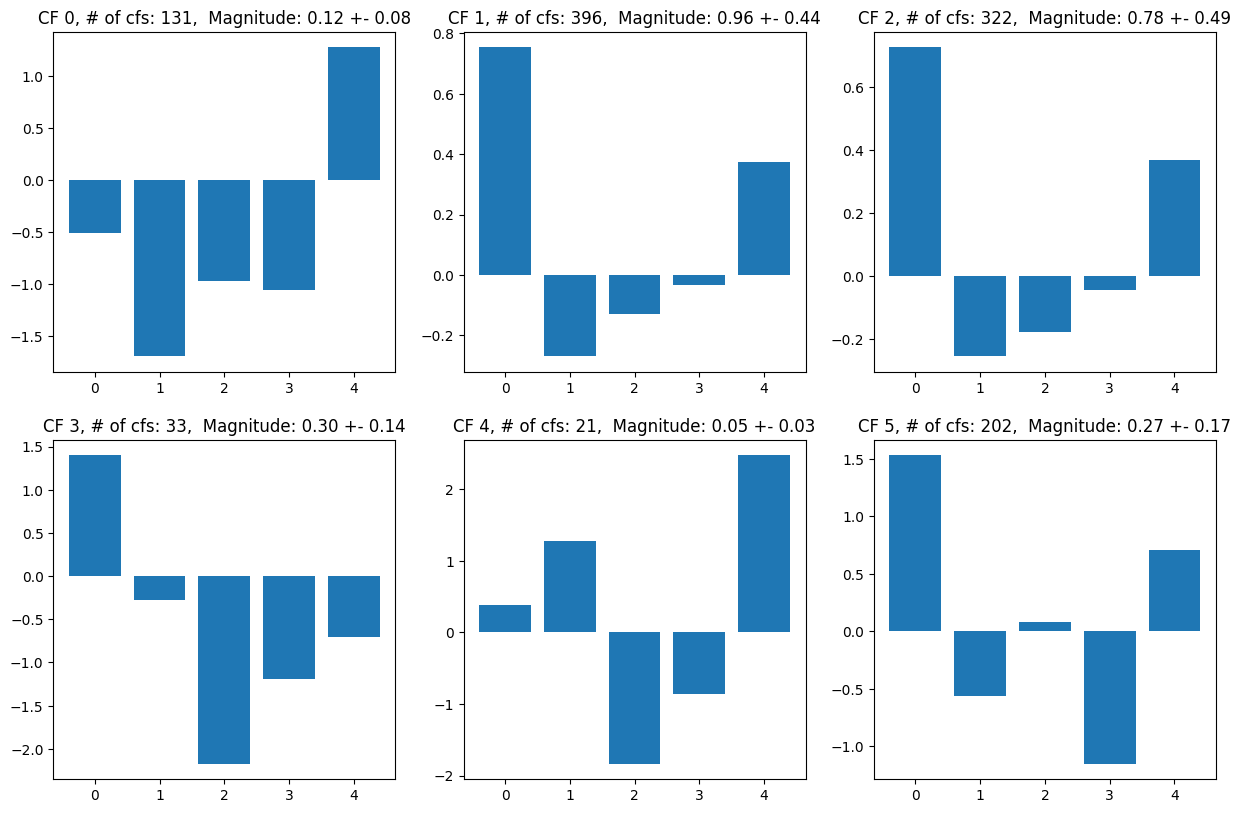

In [15]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        range(len(dataset.actionable_features)),
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

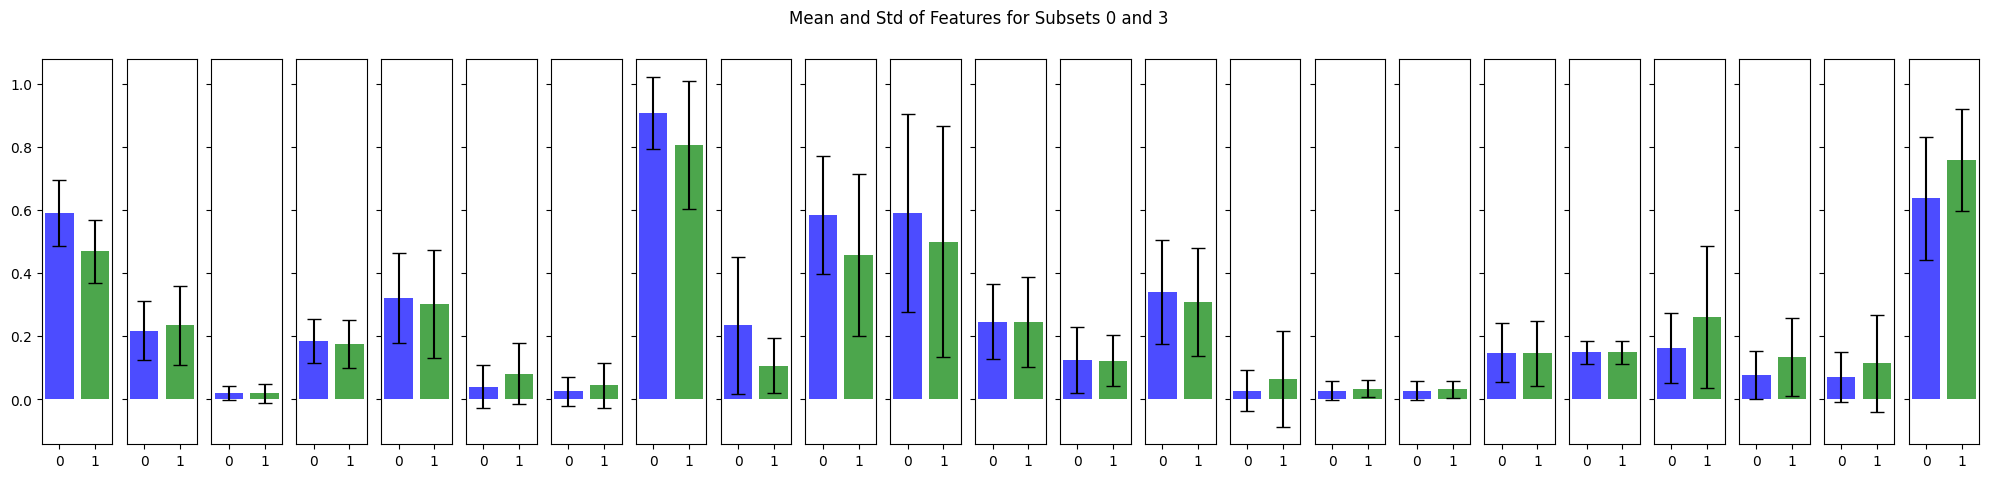

In [16]:
import matplotlib.pyplot as plt

# First subset
subset_0 = X_test_origin[S.argmax(dim=1) == 0]
mean_values_0 = subset_0.mean(axis=0)
std_values_0 = subset_0.std(axis=0)

# Second subset
subset_1 = X_test_origin[S.argmax(dim=1) == 3]
mean_values_1 = subset_1.mean(axis=0)
std_values_1 = subset_1.std(axis=0)

fig, axes = plt.subplots(1, len(mean_values_0), figsize=(25, 5), sharey=True)

for i in range(len(mean_values_0)):
    axes[i].bar(
        0, mean_values_0[i], yerr=std_values_0[i], capsize=5, color="blue", alpha=0.7
    )
    axes[i].bar(
        1, mean_values_1[i], yerr=std_values_1[i], capsize=5, color="green", alpha=0.7
    )
    axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(['Subset 0', 'Subset 1'])
    # axes[i].set_title(f'Feature {i}')

fig.suptitle("Mean and Std of Features for Subsets 0 and 3")
plt.show()